In [626]:
import numpy as np
#from scipy.linalg import cholesky
from numpy.linalg import cholesky
from matplotlib import pyplot as plt
import math

In [627]:
# hyper parameters
SET ={
    "alpha":[0.1,0.25,0.75,1,1.5],
    "beta":[0,0.5,1,2,5],
    "kappa":[0.1,0.5,1,5,10]
}   
    

In [628]:
# declare variables
P_0 = np.array([[1,0.9],[0.1,9]])
x_0 = np.transpose(np.array([[2,1]]))
#print(x_m)
#print(P_0)

In [629]:
def chol(M):
    # M= A*A.T
    A=np.array(cholesky(M.T)) #numpy
    #A = np.array(cholesky(M,lower=False)) #scipy
    return A

if False:
    M = P_0
    A=chol(M)
    M2 = np.matmul(A,A.T)
    print(f"M =\n {M}\nA*A.T=\n{M2}\n")

In [630]:
def f(x):
    y = np.array([np.sin(x[0]),np.cos(x[1])])
    #y = np.array([x[0],x[1]])
    return y


def ut_get_weights(n,alpha,beta,kappa):
    # Compute the normal weights 
    _lambda = alpha ** 2 * (n + kappa) - n

    dummy = 1 / (2 * (n + _lambda))
    WM = np.ones((2*n+1,1))*dummy
    WC = np.ones((2*n+1,1))*dummy
    WM[0] = _lambda / (n + _lambda)
    WC[0] = _lambda / (n + _lambda) + (1 - alpha ** 2 + beta)
    c = n + _lambda 

    return WM,WC,c

def ut_get_sigmaPoints(M,P,c):
   
    A = chol(P)#.T 
    #print(f"A = {A}")
    delta_X = np.concatenate((np.zeros_like(M), A, -1*A),axis=1)
    #print(delta_X)
    #print(delta_X.shape[1])
    #print(M)
    X_0 = np.tile(M,(1,delta_X.shape[1]))
    #print(f"X_0:\n{X_0}")
    X = np.sqrt(c)*delta_X + X_0
    return X


In [631]:
def fig_setup():
    fig, axs = plt.subplots(3, 2)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    titles = ["alpha","beta","kappa"]
    for i in range(3):        
        ax=axs[i,0]
        ax.set_title("Varatiation of "+titles[i])
        ax.set_xlabel("x_1")
        ax.set_ylabel("x_2")
        ax.set_xlim([-2, 6])
        ax.set_ylim([-10, 10])
        ax.grid()
        
        ax=axs[i,1]   
        ax.set_title(f"Propagation: y = f(x)")
        ax.set_xlabel("y_1")
        ax.set_ylabel("y_2")
        ax.set_xlim([-1, 3])
        #ax.set_ylim([-10, 10])
        ax.grid()
    axs[0,1].set_ylim([-10, 12])
    axs[1,1].set_ylim([-2, 3])
    axs[2,1].set_ylim([-4, 4])
    return axs

def plot_dist(ax,X,col):
    ax.plot(X[0,:],X[1,:], marker='x',linestyle = 'None',markerfacecolor=col) 

def plot_mean(ax,x_m,col):
    ax.plot(x_m[0],x_m[1], marker='o',linestyle = 'None',markerfacecolor='None',markeredgecolor=col) 

def plot_ellipse(ax,C,m,col):
    e,ev = np.linalg.eig(C)
  
    e_min = min(e)
    e_max = max(e)
    idx = e.argsort()
    ev_min=ev[:,idx[0]]
    ev_max=ev[:,idx[-1]]
    
    phi = np.arctan2(ev_max[1], ev_max[0])
    #print(f"e= {e} ; \ne_min={e_min} ; e_max={e_max} ")

    chisquare_val = 2.4477; 
    ag = np.arange(0,math.pi*2,0.05) 
    a=chisquare_val*np.sqrt(e_max) 
    b=chisquare_val*np.sqrt(e_min)

    ellipse_x_r = a*np.cos( ag )
    ellipse_y_r = b*np.sin( ag ) 
    R = np.array([[ np.cos(phi), np.sin(phi)], [-np.sin(phi), np.cos(phi)] ])

    M = np.tile(m,(1,ellipse_x_r.shape[0]))
    r_ellipse = np.matmul(np.array([ellipse_x_r,ellipse_y_r]).T,R).T+M

    ax.plot(r_ellipse[0,:],r_ellipse[1,:],color=col) 


In [632]:
def do_single_run(x_m,P_x,alpha,beta,kappa):
    # calculate sigma points
    n = x_m.shape[0]
    #print(f"n = {n}")
    WM,WC,c = ut_get_weights(n,alpha,beta,kappa)
    
    X = ut_get_sigmaPoints(x_m,P_x,c)    

    # nonlinear tranformation / propagation
    Y = np.zeros_like(X)
    for k in range(X.shape[1]):
        Y.T[k] = f(X.T[k])     
    return X,Y



In [633]:
def calc_cov_mean(X,alpha,beta,kappa):
    n=X.shape[0]
    WM,WC,c = ut_get_weights(n,alpha,beta,kappa)

    # calculate mean and covariance
    x_m = np.matmul(X,WM)
    
    W  = np.identity(n*2+1) - np.tile(WM,(1,WM.shape[1]))
    #print(f"W= {W} \n W.shape = {W.shape}")
    wcd = np.diag(WC[:,0])
    #print(f"diag(WC) = {np.diag(WC.T)} \n WC.shape = {WC.shape} \n wcd={wcd}")
    W2 = np.matmul( np.matmul(W,wcd) ,W.T)
    #print(f"W2 = {W2}")
    dX = X-np.tile(x_m,(1,WM.shape[1]))
    P_X  = np.matmul( np.matmul(dX,W2),dX.T)
    return P_X,x_m

---- Run 0
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 1
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 2
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 3
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 4
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 0
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 1
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 2
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 3
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 4
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 0
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 1
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 2
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 3
P_x=[[1.  0.9]
 [0.9 9. ]]

---- Run 4
P_x=[[1.  0.9]
 [0.9 9. ]]



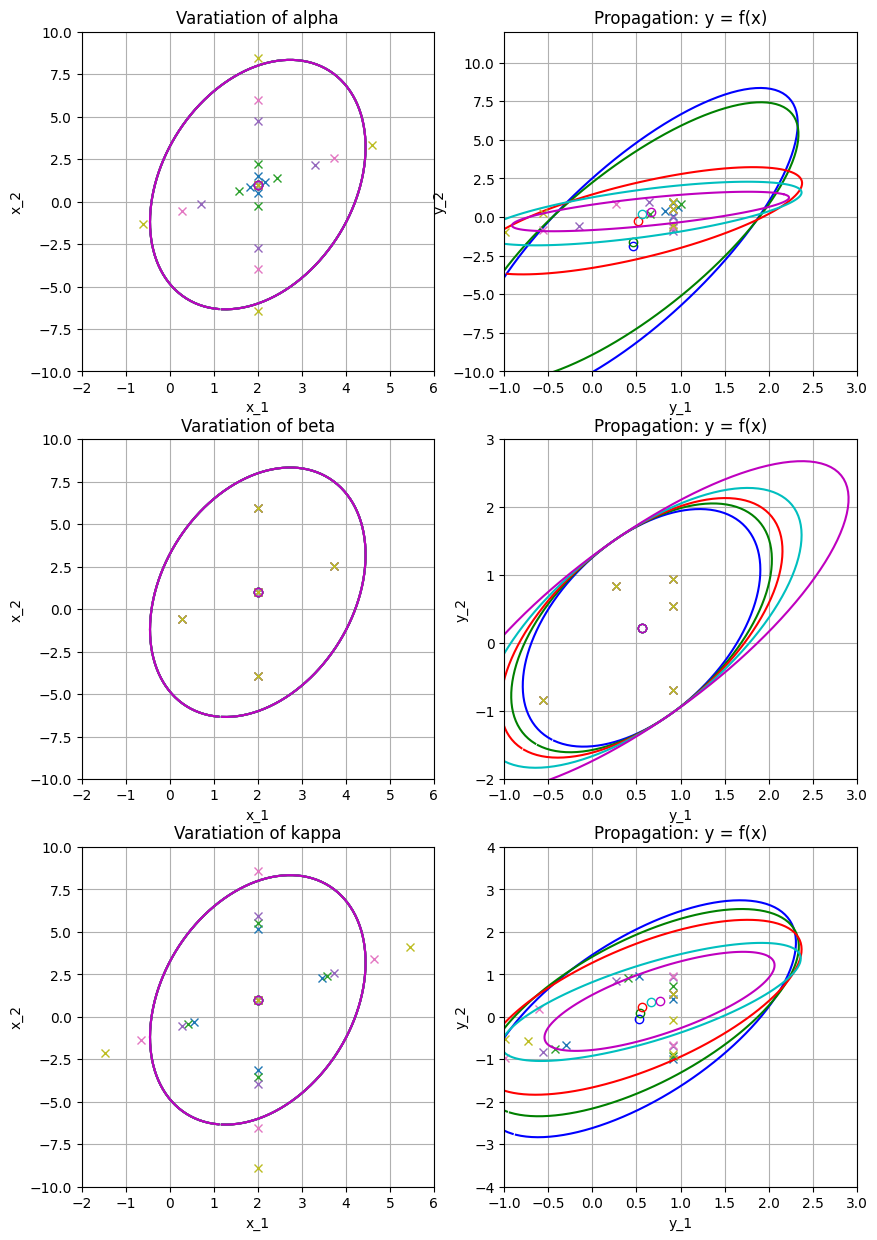

In [634]:
axs=fig_setup()
colors=['b','g','r','c','m','y','k']
alpha = 1
beta  = 2
kappa = 1

for v in range(3):
    alpha = 1
    beta  = 2
    kappa = 1
    for id in range(len(SET["alpha"])):
        print(f"=================\n---- Run {id}")
        if v == 0:
            alpha = SET["alpha"][id]
        if v == 1:
            beta = SET["beta"][id]
        if v == 2:
            kappa = SET["kappa"][id]

        X,Y = do_single_run(x_0,P_0,alpha,beta,kappa)

        P_x,x_m = calc_cov_mean(X,alpha,beta,kappa)
        P_y,y_m = calc_cov_mean(Y,alpha,beta,kappa)
        print(f"P_x={P_x}\n")
        #print(f"X = \n{X}")
        #print(f"Y = \n{Y}")
        plot_dist(axs[v,0],X,colors[id])
        plot_dist(axs[v,1],Y,colors[id])
        plot_mean(axs[v,0],x_m,colors[id])
        plot_mean(axs[v,1],y_m,colors[id])
        plot_ellipse(axs[v,0],P_x,x_m,colors[id])
        plot_ellipse(axs[v,1],P_y,y_m,colors[id])

In [635]:
z = np.array([[1,2,3]])
print(z.shape)



(1, 3)


In [636]:
%matplotlib inline
if False:
    x=np.arange(0,math.pi*2,0.05)
    y=np.sin(x)
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.plot(x,y)
    ax.set_title("sine wave")
    ax.set_xlabel("angle")
    ax.set_ylabel("sine")

In [637]:
# Testing
if True:
    x = np.array([1,1]) #*math.pi
    print(x)
    y = f(x)
    print(y)


[1 1]
[0.84147098 0.54030231]
